In [24]:
import librosa
import librosa.display
import numpy as np

In [19]:
CNN_INPUT_SIZE = (224, 224)
DEFAULT_SR = 22050

In [20]:
def resize_axis(array, N):
    if(array.shape[1] > N):
        resized = array[:,:N]
    else:
        resized = np.lib.pad(array, ((0,0),(0,N - array.shape[1])),\
            'constant', constant_values=(np.min(array)))
    return resized

In [40]:
def extract_cnn_input(raw_audio):
    frame_length = min(2048, len(raw_audio))
    mel_spec = librosa.core.power_to_db(librosa.feature.melspectrogram(
        y=raw_audio, sr=DEFAULT_SR, n_fft=frame_length,
        hop_length=frame_length//4, n_mels=CNN_INPUT_SIZE[0])
    )
    # Truncate number of frames stored
    m = min(CNN_INPUT_SIZE[1], mel_spec.shape[1])
    N =224
    mell = resize_axis(mel_spec[:, 0:m], N)
    return mell

---

In [41]:
import os

def onehot(str):
    path = './Drum'
    kits = os.listdir(path)
    #kits.remove('.DS_Store')
    
    oh = []

    for kit in kits:
        if str == kit:
            oh.append(1)
        else:
            oh.append(0)
    
    return np.array(oh)

In [42]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        yt = librosa.util.normalize(yt)
        k = extract_cnn_input(yt)
        k = np.expand_dims(k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

c:\Users\cid2r\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size=0.2)

----

In [50]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import *

img_input = Input(shape=(224, 224, 1))
img_conc = Concatenate()([img_input, img_input, img_input])  



local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=img_conc,
                              include_top=False,
                              weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.

In [29]:
for layer in model.layers:
  layer.trainable = False

In [30]:
model.summary()

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 224, 224, 3)  0           ['input_9[0][0]',                
                                                                  'input_9[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['concatenate_8[0][0]']      

In [32]:
last_layer = model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [45]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import *

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(7, activation='sigmoid')(x)

modell = Model(model.input, x)

modell.compile(optimizer=RMSprop(lr=0.0001),
            loss=tf.keras.losses.categorical_crossentropy,
            metrics=['accuracy'])

c:\Users\cid2r\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [46]:
with tf.device('/gpu:0'):
    history = modell.fit(x_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
14/14 [==============================] - 4s 243ms/step - loss: 2.4333 - accuracy: 0.1183 - val_loss: 1.9357 - val_accuracy: 0.1696
Epoch 2/20
14/14 [==============================] - 2s 143ms/step - loss: 1.9451 - accuracy: 0.1674 - val_loss: 2.0652 - val_accuracy: 0.1250
Epoch 3/20
14/14 [==============================] - 2s 143ms/step - loss: 1.9483 - accuracy: 0.1629 - val_loss: 1.9187 - val_accuracy: 0.1429
Epoch 4/20
14/14 [==============================] - 2s 143ms/step - loss: 1.9159 - accuracy: 0.2478 - val_loss: 1.8664 - val_accuracy: 0.3036
Epoch 5/20
14/14 [==============================] - 2s 143ms/step - loss: 1.8949 - accuracy: 0.2165 - val_loss: 1.8855 - val_accuracy: 0.1964
Epoch 6/20
14/14 [==============================] - 2s 143ms/step - loss: 1.8667 - accuracy: 0.2321 - val_loss: 1.8135 - val_accuracy: 0.3929
Epoch 7/20
14/14 [==============================] - 2s 143ms/step - loss: 1.8363 - accuracy: 0.2723 - val_loss: 1.9730 - val_accuracy: 0.1786
Epoch 

In [47]:
Y_pred = modell.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)

Y_Lab = np.argmax(y_test, axis = 1)

<AxesSubplot:>

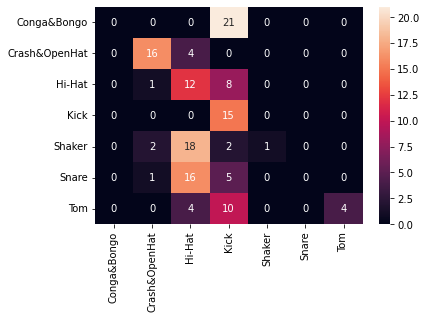

In [48]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

classes = ['Conga&Bongo', 'Crash&OpenHat', 'Hi-Hat', 'Kick', 'Shaker', 'Snare', 'Tom']

cm = pd.DataFrame(confusion_matrix(Y_Lab, Y_pred_classes), columns=classes, index=classes)
sns.heatmap(cm, annot=True)